#### **Import necessary libraries**

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [129]:
def plot_residuals(y_test, y_pred, title="Residuals vs. Fitted Values"):
    """
    Plots residuals vs. fitted values for regression models.

    Parameters:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        title (str): Title of the plot (default: "Residuals vs. Fitted Values").
    
    Returns:
        None
    """
    residuals = y_test - y_pred

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(title)
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### **Load Data**

In [130]:
file_path = "../resources/data/output/customer_churn_prepared.csv"   
df = pd.read_csv(file_path)

In [131]:
df.head()

,call_failure,complains,subscription_length,charge_amount,seconds_of_use,frequency_of_SMS,distinct_called_numbers,age_group,tariff_plan,status,customer_value,churn
0,8,0,38,0,4370,5,17,3,1,1,197.640,0
1,0,0,39,0,318,7,4,2,1,2,46.035,0
2,10,0,37,0,2453,359,24,3,1,1,1536.520,0
3,10,0,38,0,4198,1,35,1,1,1,240.020,0
4,3,0,38,0,2393,2,33,1,1,1,145.805,0


#### **Input and Target Features**

In [132]:
X = df.drop(columns=["customer_value", "churn"])
y = df["customer_value"]

In [133]:
y_log = np.log1p(y)

#### **Numeric and Categorical features**

In [134]:
numeric_features = [
    "call_failure",
    "complains",
    "seconds_of_use",
    "frequency_of_SMS",
    "distinct_called_numbers",
    "charge_amount",
    "subscription_length"
]
categorical_features = [ "tariff_plan", "age_group", "status"]

#### **Base Model**

In [135]:
# 1. Preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features)
])

In [136]:
# 2. Pipeline
baseline_tree = Pipeline([
    ("preprocessor", preprocessor),
    ("dt", DecisionTreeRegressor(random_state=42))
])


In [137]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [138]:
# 4. Fit & predict
baseline_tree.fit(X_train, y_train)
y_pred = baseline_tree.predict(X_test)

#### **Evaluate Base Model**

#### RMSE and R2

In [139]:
#Evaluate
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree Regression - RMSE: {rmse:.2f}, R2 Score: {r2:.4f}")

Decision Tree Regression - RMSE: 0.01, R2 Score: 0.9909


- The R² score of 0.9909 indicates the model explains 99.09% of the variance in the data
- The very low RMSE (0.01) confirms the model's predictions are highly accurate

#### Plot residuals vs fitted

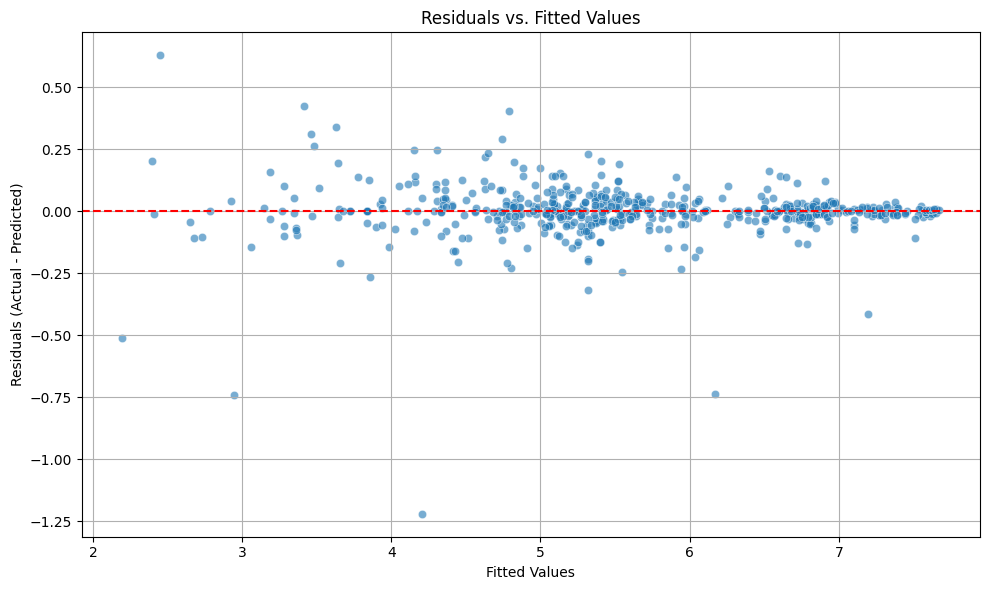

In [140]:
plot_residuals(y_test, y_pred, "Residuals vs. Fitted Values")

- The points are fairly evenly scattered around the zero line, indicating good model fit.
- Most residuals fall within ±0.25 range, with only a few outliers beyond these bounds.

#### **Cross Validation**

In [141]:
from sklearn.model_selection import cross_val_score

# Reuse the same pipeline
neg_rmse_scores = cross_val_score(baseline_tree, X, y_log, scoring='neg_root_mean_squared_error', cv=5)
r2_scores = cross_val_score(baseline_tree, X, y_log, scoring='r2', cv=5)

print(f"\nCross-validated RMSE scores: {-neg_rmse_scores}")
print(f"Average RMSE: {-neg_rmse_scores.mean():.2f}")
print(f"Cross-validated R2 scores: {r2_scores}")
print(f"Average R2: {r2_scores.mean():.4f}")


Cross-validated RMSE scores: [0.08782355 0.120578   0.13951055 0.09788887 0.15727675]
Average RMSE: 0.12
Cross-validated R2 scores: [0.99427486 0.99047068 0.98744691 0.99278676 0.9803443 ]
Average R2: 0.9891


#### **Evaluate Cross Validated Model**

The cross-validated results show strong and consistent model performance:

- The average RMSE of 0.12 is higher than the single test score (0.01), providing a more realistic estimate of model performance across different data splits
- The average R² score of 0.9891 remains exceptionally high, indicating the model consistently explains about 98.91% of the variance in the data
- The scores across all 5 folds are stable, with R² ranging from 0.980 to 0.994, suggesting the model is robust and generalizes well

These cross-validation results confirm the model's strong predictive capability for Customer Lifetime Value, though with slightly more error than indicated by the single test split.

#### Plot residuals vs fitted

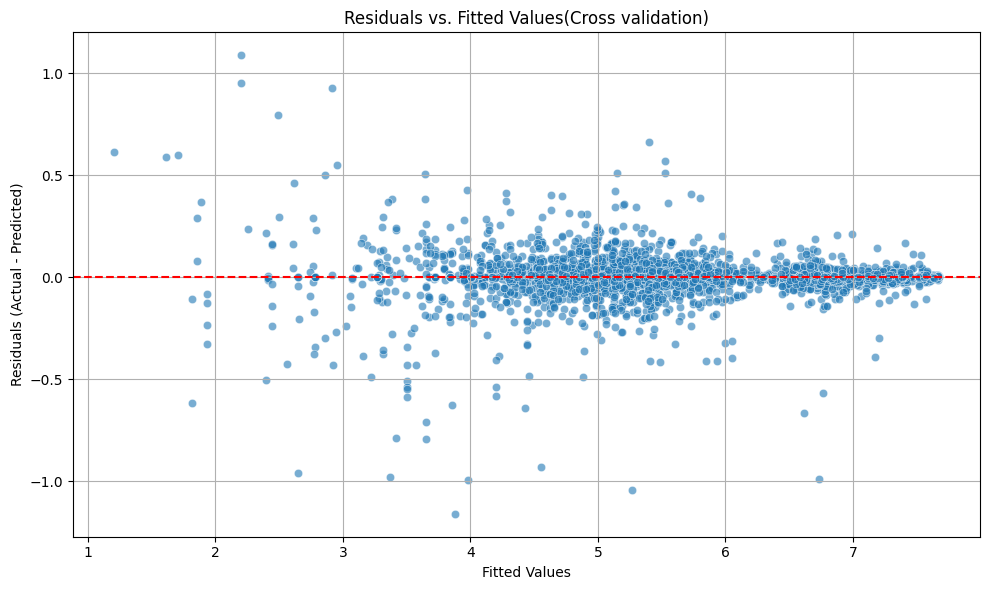

In [145]:
from sklearn.model_selection import cross_val_predict

# Get cross-validated predictions
y_pred_cv = cross_val_predict(baseline_tree, X, y_log, cv=5)

# Plot residual
plot_residuals(y_log, y_pred_cv, "Residuals vs. Fitted Values(Cross validation)")

- The residuals are mostly clustered around the zero line, indicating generally good predictions
- Most residuals fall within ±0.5 range, with a few outliers reaching ±1.0
- The spread of residuals is fairly consistent across different CLV values suggesting homoscedasticity
- There's slightly more variance in residuals for lower CLV values (1-3) compared to higher values

This confirms the strong cross-validation performance, though with slightly higher error than the single test split.

In [126]:
residuals_cv = y_log - y_pred_cv

##### Histogram (log residuals)

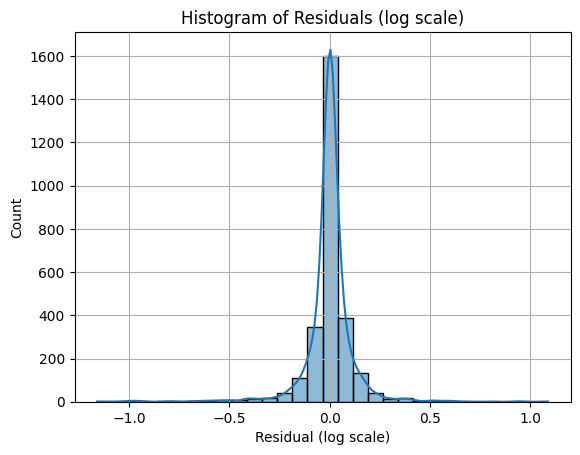

In [146]:
sns.histplot(residuals_cv, kde=True, bins=30)
plt.title("Histogram of Residuals (log scale)")
plt.xlabel("Residual (log scale)")
plt.grid(True)
plt.show()

- A strong normal distribution centered around zero, indicating well-balanced prediction errors
- Most residuals are tightly clustered between -0.2 and 0.2, showing high prediction accuracy
- Very few extreme residuals beyond ±0.5, with almost none reaching ±1.0
- The symmetric shape suggests the model is not systematically over- or under-predicting

This distribution confirms the model's excellent performance in predicting Customer Lifetime Value, with most predictions being very close to actual values.

##### Scatter Plot: Actual vs. Predicted CLV (Real World)

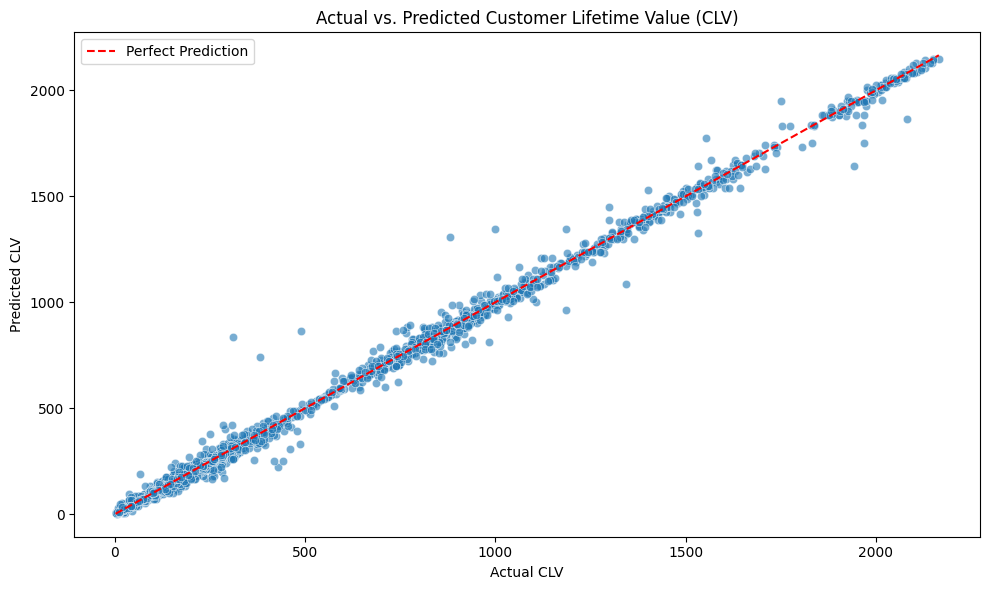

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = np.expm1(y_pred_cv)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()],
         color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs. Predicted Customer Lifetime Value (CLV)")
plt.legend()
plt.tight_layout()
plt.show()

The plot of Actual vs. Predicted Customer Lifetime Value (CLV):

- Points closely follow the red dashed "Perfect Prediction" line across all CLV values (0-2000).
- Very few points deviate significantly from the line, indicating consistent accuracy across the value range.
- The model performs well for both low and high CLV customers, with no systematic bias.

#### **Persist the model**

In [148]:
import joblib

# Fit the pipeline on the full training data
baseline_tree.fit(X, y_log)

# Save the entire pipeline to a file
joblib.dump(baseline_tree, '../resources/data/output/Decision_tree_regression_model_final.pkl')

['../resources/data/output/Decision_tree_regression_model_final.pkl']